### Partition face dataset into 8:2 training:test

### Apply PCA on training data by use of eigenvectors and eigenvalues of covaraiance matrix S= (1/N)A(A^T)

### Apply PCA using eigenvectors and eigenvalues of (1/N)(A^T)A

In [165]:
# PCA source: Week 2 slides - Manifold Learning

import numpy as np
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

data = loadmat('face.mat')

X = data['X'] # flat images dim (2576,520)
l = data['l'].flatten()  # image Labels (1,520)

X_train, X_test, y_train, y_test = train_test_split(X.T, l, test_size=0.2, random_state=42)
# X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (416, 2576)
Test set shape: (104, 2576)


In [166]:
def display_image(image, label):
    # X[:, image_index]
    image_height, image_width = 46, 56 
    image = image.reshape((image_height, image_width)).T 
    # label = l[image_index]

    plt.imshow(image, cmap='gray', aspect='auto')
    plt.title(f"Face Image - Label: {label}")
    plt.axis('off')
    plt.show()

In [167]:
print(X_train.shape)
X_train_mean = np.mean(X_train, axis=0)
print(X_train_mean.shape)


(416, 2576)
(2576,)


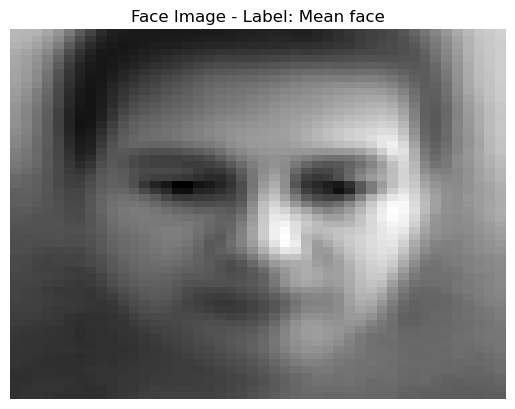

None


In [168]:
X_train_mean = np.mean(X_train, axis=0)
A = X_train - X_train_mean
N = A.shape[1]
print(display_image(X_train_mean, "Mean face"))

In [169]:
def get_sorted_eigen(M):
    eigenvalues, eigenvectors = np.linalg.eig(M)

    sorted_indices = np.argsort(eigenvalues)[::-1]

    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    return sorted_eigenvalues, sorted_eigenvectors

In [170]:
# S = Covariance Matrix, A = mean centred data, N = #samples
def PCA(A,N):
    S = (1/N) * np.dot(A, A.T)
    return get_sorted_eigen(S)

In [171]:
# They cannot possibly be the same since they have different dimensions. 



##### Look here FELIX - AAT: S = (1/N) A * A^T, ATA: S = (1/N) A^T * A  
eigenvalues_AAT, eigenvectors_AAT = PCA(A,N)
eigenvalues_ATA, eigenvectors_ATA = PCA(A.T,N)
##########